In [3]:
%matplotlib widget
import CoolProp 
from CoolProp.CoolProp import PropsSI
import pandas as pd
import numpy as np
import glob,sys,socket,fileinput
import os.path
import matplotlib.pyplot as plt
import scipy.signal as signal
import tikzplotlib
from IPython.display import Latex


mk = ['o','s','v','d','p','>']



In [4]:
#FUNCION DETECTORA DE PICOS

def xlookup(lookup_value, lookup_array, return_array, if_not_found:str = ''):
    match_value = return_array.loc[lookup_array  ==  lookup_value]
    if match_value.empty:
        return f'"{lookup_value}" not found!' if if_not_found  ==  '' else if_not_found

    else:
        return match_value.tolist()[0]


class medida:
    def __init__(self,direccion, espesor, largo):
        strdireccion = direccion
        
        self.largo_str = f'{int(largo):04d}'
        self.espesor_str = f'{int(espesor):03d}'
        self.direccion = direccion
        self.espesor = espesor
        self.largo = largo
        carpeta = self.curva()
        self.RawDataFolder = str(carpeta)+"/"
        self.files = np.sort(glob.glob(self.RawDataFolder+'*.txt'))
        VoltMedicion = np.array([float(files_i.split('/V')[-1][:2]) for files_i in self.files])
        self.VelocidadMedicion = Velocity_Volt(VoltMedicion)
        self.ReMedicion = self.VelocidadMedicion*D*rho/mu
        
        
        self.df,self.mediaDrag, self.mediaLift,self.stdLift,self.stdDrag = [[],[],[],[],[]]
        self.mediaDrag, self.mediaLift,self.stdLift,self.stdDrag,self.freqpeak,self.St = np.tile(np.zeros((1,len(self.files))),[6,1])
        
        for i,k in enumerate(self.files):
            #Importo los datos y le saco datos de cabeza y de cola
            datos = pd.read_csv(k, sep = ",", header = None,skiprows = 5)
            datos = datos[:-100]
            datos.columns = ["Time", "Frequency", "Drag", "Lift"]
            datos = datos.astype(float)
            datos = datos[800:2500]
            if i == 0:
                dragref = datos["Drag"].mean()
                liftref = datos["Lift"].mean()
            mediaLift = datos["Lift"].mean()
            stdLift = datos["Lift"].std()
            mediaDrag = datos["Drag"].mean()
            stdDrag = datos["Drag"].std()
            
            for k in datos.index:
                if datos["Drag"][k]>(mediaDrag+200*stdDrag):
                    datos["Drag"][k] = np.nan
                if datos["Drag"][k]<(mediaDrag-200*stdDrag):
                    datos["Drag"][k] = np.nan

            
            # reemplaza nans  interpolando
            datos.interpolate(method  = 'linear', limit_direction  = 'backward', inplace = True)
            
            self.df.append(datos)
            self.mediaLift[i] = datos["Lift"].mean()-liftref
            self.stdLift[i] = datos["Lift"].std()
            self.mediaDrag[i] = datos["Drag"].mean()-dragref
            self.stdDrag[i] = datos["Drag"].std() 
            
            #LS para ver frecuencais
            tiempos = (datos["Time"].values)/1000
            tiempos = tiempos-np.min(tiempos)
            fuerzas = datos["Drag"].values
            fuerzas = fuerzas-np.mean(fuerzas)
            freqs = np.fft.fftfreq(len(fuerzas),tiempos[1])
            Fuerzas = np.abs(np.fft.fft(fuerzas))
            Fuerzas = Fuerzas[freqs>0]
            freqs = freqs[freqs>0]
            self.freqpeak[i] = freqs[Fuerzas.argmax()]
            self.St[i] = self.freqpeak[i]/self.VelocidadMedicion[i]*D
    
    def curva(self):
        a = str(str(self.direccion) + R"/e" + str(self.espesor_str) +R"/l"+str(self.largo_str))
        return a   
    
    
VelocityFile = "Velocidades Calibradas/Velocidades.txt"
VelocityData = pd.read_csv(VelocityFile)
PolinomioVelocidad = np.polyfit(VelocityData["V [V]"],VelocityData["U [m/s]"],1)
Velocity_Volt = np.poly1d(PolinomioVelocidad)

In [5]:
#CARGA DE DATOS
D = 50/1000 #Diametro de la parte cilindrica [m]
T = 273.15+18
rho = PropsSI('D', 'T',T , 'P', 1e5, 'AIR') #Densidad del aire [kg/m3]
mu = PropsSI('V', 'T', T, 'P', 1e5, 'AIR') #Viscocidad del aire [Pa. s]
L = 0.175*2 #Largo del cilindro en metros
A = D*L ## area proyectada

In [6]:
Dref_a = medida("Drag", 0, 0)
Dref_b = medida("Lift", "000", "0000")


(0.0, 0.3)

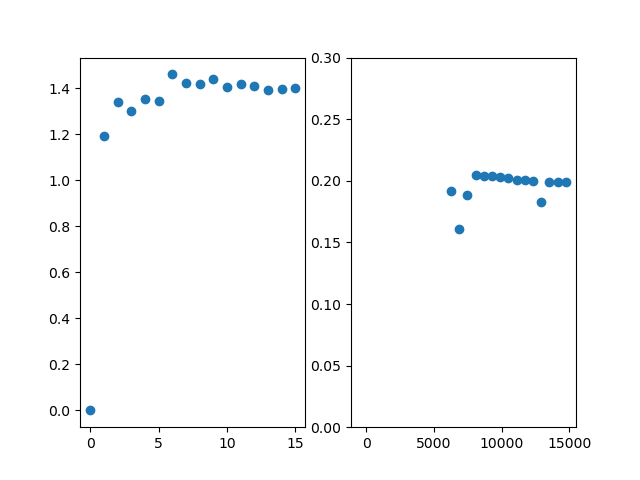

In [7]:
fig,ax = plt.subplots(1,2)
ax1,ax2 = ax
ax1.plot(Dref_a.mediaDrag/Dref_a.VelocidadMedicion**2,'o')
ax2.plot(Dref_a.ReMedicion,Dref_a.St,'o')
ax2.set_ylim([0,0.3])

In [8]:
dir_espesores = os.listdir('Lift')
espesores = np.sort(np.array([float(esp_i[1:]) for esp_i in dir_espesores]))

dir_largos = os.listdir('Lift/e030')
largos = np.sort(np.array([float(largo_i[1:]) for largo_i in dir_largos]))

In [9]:

casos1 = []
for i,espesor in enumerate(espesores[1:]):
    casos1.append(medida('Drag',espesor,largos[0]))
casos2 = []
for i,espesor in enumerate(espesores[1:]):
    casos2.append(medida('Drag',espesor,largos[1]))    
    
casos3 = []
for i,espesor in enumerate(espesores[1:]):
    casos3.append(medida('Drag',espesor,largos[2]))
casos4 = []
for i,espesor in enumerate(espesores[1:]):
    casos4.append(medida('Drag',espesor,largos[3]))  
casos5 = []
for i,espesor in enumerate(espesores[1:]):
    casos5.append(medida('Drag',espesor,largos[4]))  

In [21]:
# frecuencia natural
espesores = np.array([25,75,100,175])*1e-3
Yms = np.array([10.3,50.5,62.2,91.7])
mgs = np.array([0.09,0.27,0.34,0.64])
Areas = np.array([2500e-6])
#c = (B/ρhf)^1/3
cs = 1.103*Yms
rhos = mgs/Areas/espesores
#wn = kn
Bs = cs**3*rhos*espesores

In [22]:
Bs

array([5.27886690e+04, 1.86648467e+07, 4.39173978e+07, 2.64895457e+08])

In [8]:
# Ejemplo y determinacion de error

t, fr,D,L = casos5[0].df[0].T.to_numpy()
eD = np.abs(D.std()/D.mean())
Latex(f'error relativo $e_D = {eD*100:.2f}\%$')

<IPython.core.display.Latex object>

In [10]:
casos5[0].df[0]

,Time,Frequency,Drag,Lift
800,9270.0,90.91,-201.84,0.0
801,9281.0,90.91,-201.37,0.0
802,9293.0,83.33,-201.41,0.0
803,9305.0,83.33,-201.07,0.0
804,9316.0,90.91,-200.63,0.0
...,...,...,...,...
2495,28651.0,90.91,-200.70,0.0
2496,28662.0,90.91,-201.06,0.0
2497,28674.0,83.33,-200.75,0.0
2498,28685.0,90.91,-200.91,0.0


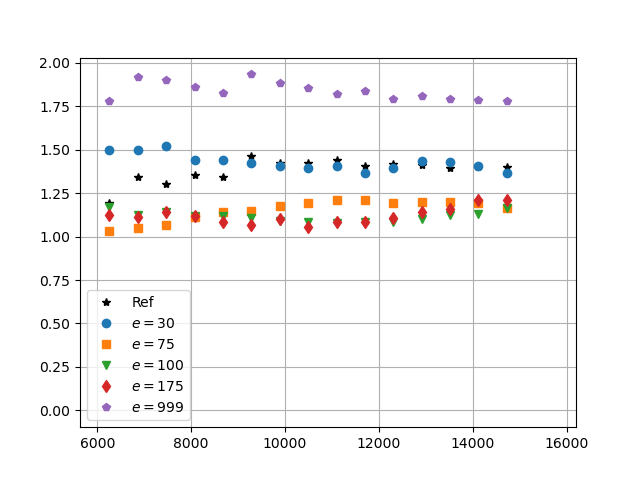

In [11]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion,Dref_a.mediaDrag/Dref_a.VelocidadMedicion**2,marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos1):
    ax.plot(casoi.ReMedicion,casoi.mediaDrag/casoi.VelocidadMedicion**2,marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()

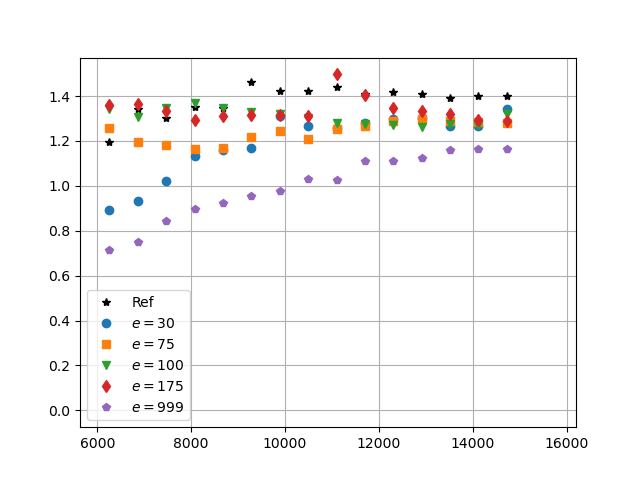

In [14]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion,Dref_a.mediaDrag/Dref_a.VelocidadMedicion**2,marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos2):
    ax.plot(casoi.ReMedicion,casoi.mediaDrag/casoi.VelocidadMedicion**2,marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()

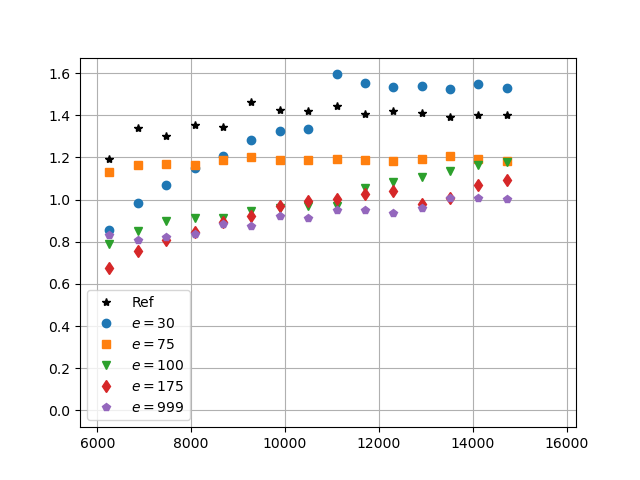

In [15]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion,Dref_a.mediaDrag/Dref_a.VelocidadMedicion**2,marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos3):
    ax.plot(casoi.ReMedicion,casoi.mediaDrag/casoi.VelocidadMedicion**2,marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()

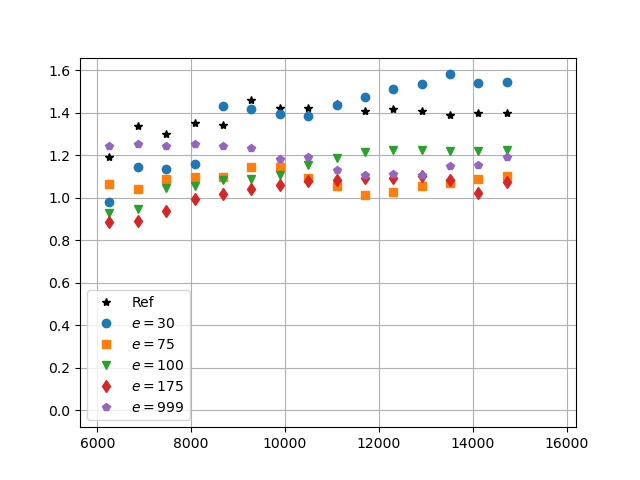

In [16]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion,Dref_a.mediaDrag/Dref_a.VelocidadMedicion**2,marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos4):
    ax.plot(casoi.ReMedicion,casoi.mediaDrag/casoi.VelocidadMedicion**2,marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()

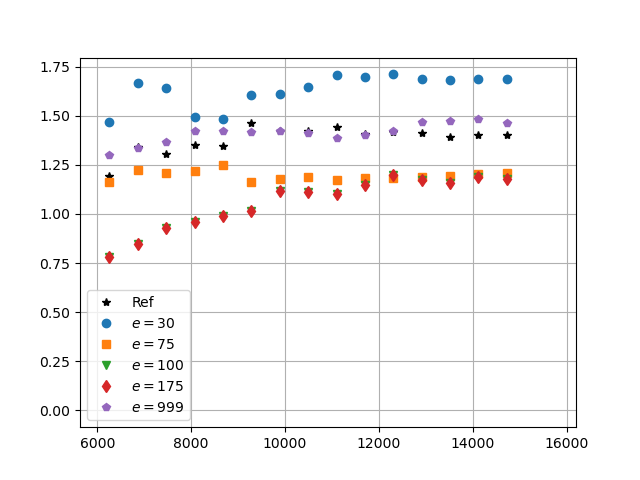

In [12]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion,Dref_a.mediaDrag/Dref_a.VelocidadMedicion**2,marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos5):
    ax.plot(casoi.ReMedicion,casoi.mediaDrag/casoi.VelocidadMedicion**2,marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()

In [20]:
casos3[0].largo

500.0

(0.0, 0.3)

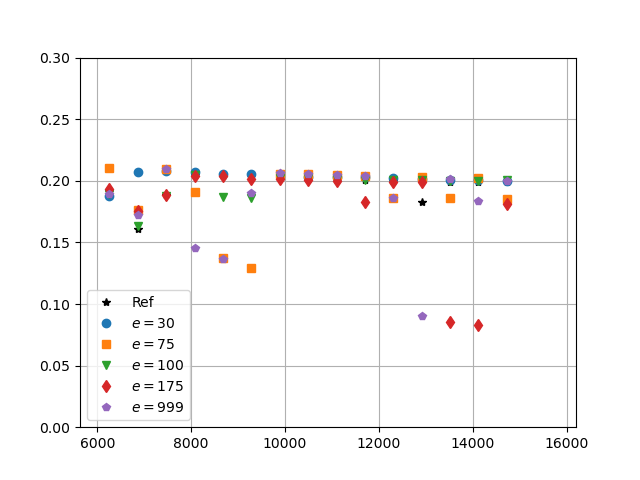

In [20]:
#STROUHAL
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion[1:],Dref_a.St[1:],marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos1):
    ax.plot(casoi.ReMedicion[1:],casoi.St[1:],marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()
ax.set_ylim([0,0.3])

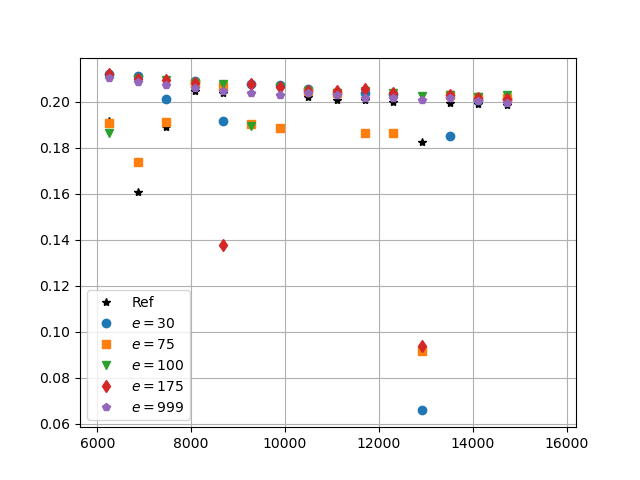

In [19]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion[1:],Dref_a.St[1:],marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos2):
    ax.plot(casoi.ReMedicion[1:],casoi.St[1:],marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()

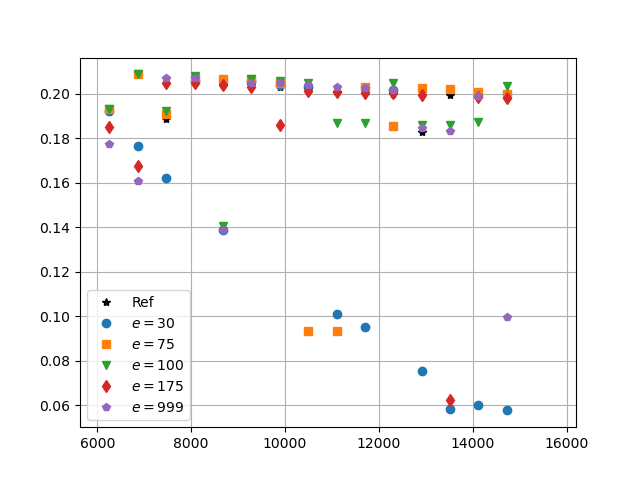

In [21]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion[1:],Dref_a.St[1:],marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos3):
    ax.plot(casoi.ReMedicion[1:],casoi.St[1:],marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()

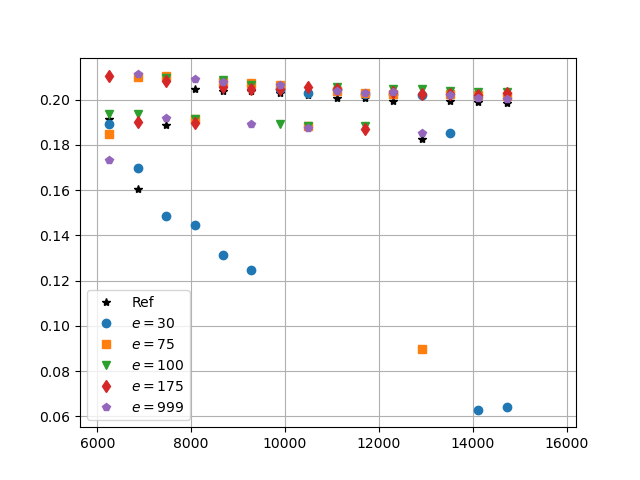

In [22]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion[1:],Dref_a.St[1:],marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos4):
    ax.plot(casoi.ReMedicion[1:],casoi.St[1:],marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()

(0.0, 0.3)

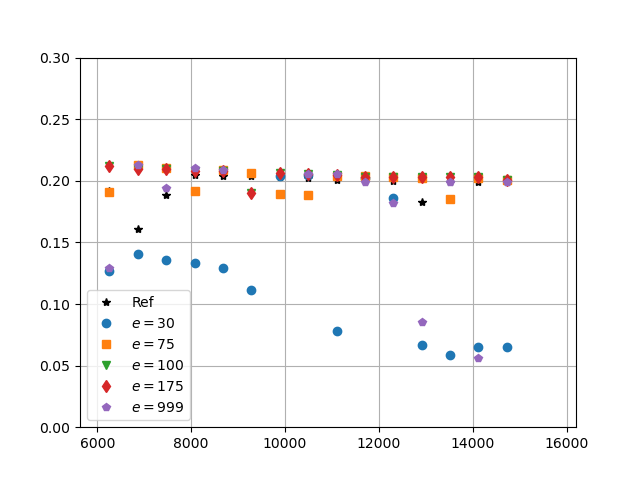

In [24]:
fig,ax = plt.subplots()
ax.plot(Dref_a.ReMedicion[1:],Dref_a.St[1:],marker='*',color='black',label='Ref',linestyle='none')
for i,casoi in enumerate(casos5):
    ax.plot(casoi.ReMedicion[1:],casoi.St[1:],marker=mk[i],linestyle='none',label=f'$e={casoi.espesor:.0f}$')
ax.set_xlim([casoi.ReMedicion[1]*.9,casoi.ReMedicion[-1]*1.1])
ax.grid()
ax.legend()
ax.set_ylim([0,0.3])